 ¿Cómo lo vamos a hacer?
Vamos a seguir esta lógica:

Obtenemos las noticias del calendario económico usando tu código original.

Filtramos las noticias relevantes (por ejemplo, de EE.UU. y con alto impacto).

Calculamos un "índice de impacto económico" para cada día, por ejemplo:

Si hay muchas noticias de alto impacto, el valor será mayor.

Si hay pocas o ninguna, el valor será cercano a 0.

Unimos ese valor a tu dataframe df de precios históricos de COIN.

Finalmente, alimentamos ese valor como una segunda característica al modelo LSTM.

In [1]:
# ==============================
# 📦 LIBRERÍAS Y CONFIGURACIÓN
# ==============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ib_insync import *
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import requests
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo

In [2]:
#utilizamos util para hacer correr el codigo en jupiter
util.startLoop()

In [3]:
#Conexion con TWS para obtener los datos
ib = IB()
ib.connect('127.0.0.1', 7497, clientId=1)

<IB connected to 127.0.0.1:7497 clientId=1>

Error 1100, reqId -1: Conectividad entre IB y TWS ha sido perdida
Error 1102, reqId -1: Conectividad entre IB y TWS ha sido restaurada - datos mantenidos: Todos los centros de datos est\u00e1n conectados: usfarm.nj; cashfarm; usfarm; cashhmds; ushmds; secdefnj.


In [4]:
# se pone primero el activo, el tipo de contrato y en que moneda se efectua
contract = Stock('COIN', 'SMART', 'USD')


In [5]:
# Se pone las caracterias del activo 
bars = ib.reqHistoricalData(
    contract,
    endDateTime='',
    durationStr='60 D',
    barSizeSetting='1 day',
    whatToShow='TRADES',
    useRTH=True,
    formatDate=1
)

In [6]:
#Se almacena en un dataframe los datos
#Se hacen algunos cambios, limpieza y orden, de la fecha y precio con pandas
df = pd.DataFrame(bars)
df['Fecha'] = pd.to_datetime(df['date'])
df['Precio'] = df['close']

In [8]:
# ==============================
# 📰 CALENDARIO ECONÓMICO
# ==============================
# el submodulo ZoneInfo de zoneinfo nos ayuda para establecer la hora del lugar, pais que desees
today = datetime.now(ZoneInfo("America/Lima")).date()
desde = today.isoformat() + 'T00:00:00.000Z'
hasta = (today + timedelta(days=3)).isoformat() + 'T23:59:59.999Z'


In [9]:
# Establesco el encabezado de la pagina,  y de donde a donde va ir.
headers = {'Origin': 'https://www.tradingview.com'}
params = {'from': desde, 'to': hasta}

In [10]:
#En la url pongo la pagina que voy a extraer los datos
#En response es para obtener los datos de la pagina, con las variables url, headers, y params
url = 'https://economic-calendar.tradingview.com/events'
response = requests.get(url, headers=headers, params=params)

In [11]:
#Almacenamos en una variable el impacto diario
impacto_diario = pd.DataFrame()

In [12]:
#Obtenemos los datos de tradingview, el calendario economico
if response.status_code == 200:
    data = response.json()
    eventos = data.get('result', [])
    calendario_df = pd.DataFrame(eventos)

    if 'date' in calendario_df.columns:
        calendario_df['datetime_utc'] = pd.to_datetime(calendario_df['date'], utc=True)
        calendario_df['datetime_peru'] = calendario_df['datetime_utc'].dt.tz_convert('America/Lima')
        calendario_df['fecha'] = calendario_df['datetime_peru'].dt.date

        # Solo eventos de EE.UU. de alto impacto
        calendario_df = calendario_df[
            (calendario_df['country'] == 'US') &
            (calendario_df['importance'] == 'high')
        ]

        # Contar eventos por día
        impacto_diario = calendario_df.groupby('fecha').size().reset_index(name='impacto')
else:
    print(f"Error al obtener los datos: {response.status_code}")

In [13]:
# ==============================
# 📈 COMBINAR CON DATOS DE COIN
# ==============================
df['fecha'] = df['Fecha'].dt.date
df = df.merge(impacto_diario, how='left', on='fecha')
df['impacto'] = df['impacto'].fillna(0)  # Si no hubo eventos ese día, poner 0

In [14]:
# ==============================
# ⚙️ NORMALIZACIÓN
# ==============================
scaler_precio = MinMaxScaler()
scaler_impacto = MinMaxScaler()

df['Precio_Normalizado'] = scaler_precio.fit_transform(df[['Precio']])
df['Impacto_Normalizado'] = scaler_impacto.fit_transform(df[['impacto']])


In [15]:
# ==============================
# 🔁 CREAR SECUENCIAS PARA LSTM
# ==============================
def create_sequences(data, seq_length=10):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        precio_seq = data[['Precio_Normalizado', 'Impacto_Normalizado']].values[i:i+seq_length]
        sequences.append(precio_seq)
        labels.append(data['Precio_Normalizado'].values[i + seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 10
X, y = create_sequences(df, seq_length)

In [16]:
# ==============================
# 🧠 MODELO LSTM
# ==============================
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 2)),  # <== ahora input con 2 features
    LSTM(50, return_sequences=False),
    Dense(25, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\alex_\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
# ==============================
# 🏋️ ENTRENAMIENTO
# ==============================
model.fit(X, y, epochs=50, batch_size=8, verbose=1)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1573
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0155 
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0164 
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0141 
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0130 
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0137 
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0098 
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0120 
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0113 
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0127 
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0111 
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0096 
Epoch 13/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0108 
Epoch 14/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0140 
Epoch 15/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0110 
Epoch 16/50
7/7 ━━━━━━━━━━━━━━━━━━━

In [18]:
# ==============================
# 🔮 PREDICCIÓN FINAL
# ==============================
last_seq = df[['Precio_Normalizado', 'Impacto_Normalizado']].values[-seq_length:]
last_seq = last_seq.reshape(1, seq_length, 2)
prediction = model.predict(last_seq)
predicted_price = scaler_precio.inverse_transform(prediction.reshape(-1, 1))[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


In [ ]:
# ==============================
# 📊 ESTABLECEMOS LOS DATOS DE FIBONACCI Y EL PRECIO MINIMO Y MAXIMO
# ==============================
max_price = df['Precio'].max()
min_price = df['Precio'].min()
diff = max_price - min_price
fibonacci_levels = [0.236, 0.382, 0.5, 0.618, 0.786]
fib_lines = [max_price - diff * level for level in fibonacci_levels]

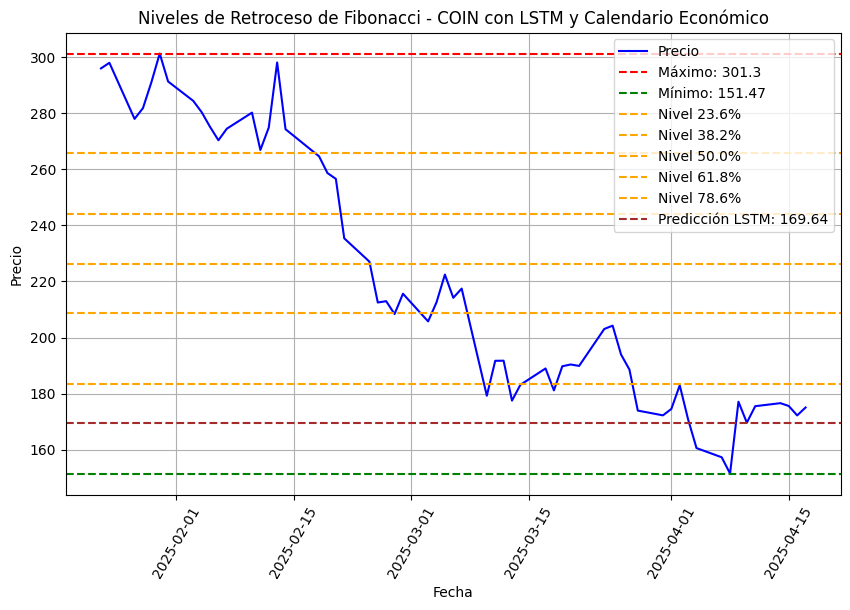

In [27]:
# Aqui se va a mostrar el grafico con las predicciones que va a realizar mi modelo de AI
plt.figure(figsize=(10, 6))
plt.plot(df['Fecha'], df['Precio'], label='Precio', color='blue')
plt.axhline(y=max_price, linestyle='--', color='red', label=f'Máximo: {max_price}')
plt.axhline(y=min_price, linestyle='--', color='green', label=f'Mínimo: {min_price}')
plt.xticks(rotation=60)

for level, line in zip(fibonacci_levels, fib_lines):
    plt.axhline(y=line, linestyle='--', color='orange', label=f'Nivel {level*100:.1f}%')

plt.axhline(y=predicted_price, linestyle='--', color='brown', label=f'Predicción LSTM: {predicted_price:.2f}')

plt.legend()
plt.title('Niveles de Retroceso de Fibonacci - COIN con LSTM y Calendario Económico')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.grid()
plt.show()

In [28]:
ib.disconnect()